In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malicious-urls-dataset/malicious_phish.csv


In [2]:
!pip install whois
!pip install colorama
!pip install tldextract
!pip install tld

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 4.0 MB/s eta 0:00:00


In [3]:
from tldextract import extract as tld_extract
from tld import get_tld, is_tld
from tld.exceptions import TldDomainNotFound, TldBadUrl, TldIOError

from colorama import Fore
from datetime import datetime
from plotly.subplots import make_subplots
from plotly import graph_objects as go
from wordcloud import WordCloud
from gensim.models import Word2Vec
import tldextract
import hashlib
import whois
import warnings
import pandas as pd
import matplotlib.pyplot as plt


In [4]:
urls_data = pd.read_csv('/kaggle/input/malicious-urls-dataset/malicious_phish.csv')

In [5]:
count = urls_data['type'].value_counts()
colors = [
    '#FF6633', '#FFB399', '#FF33FF', '#FFFF99', '#00B3E6',
    '#E6B333', '#3366E6', '#999966', '#99FF99', '#B34D4D'
]
fig = go.Figure(data=[go.Bar(x=count.index, y=count, marker=dict(color=colors))])
fig.update_layout(
    xaxis_title='Types',
    yaxis_title='Count',
    title='Count of Different Types of URLs',
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(color='white')
)
fig.update_xaxes(tickfont=dict(color='white'))
fig.update_yaxes(tickfont=dict(color='white'))
fig.show()

# Save the figure as a PNG file


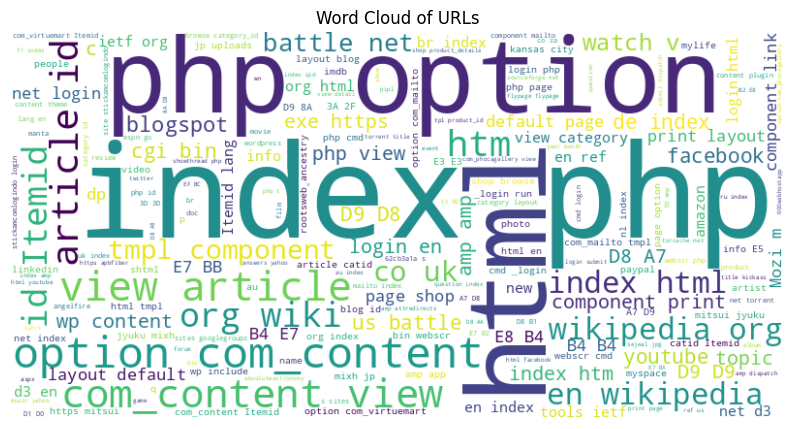

In [6]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(urls_data['url']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of URLs')
plt.show()

In [7]:
def get_url_length(url):
    # Remove common prefixes
    prefixes = ['http://', 'https://']
    for prefix in prefixes:
        if url.startswith(prefix):
            url = url[len(prefix):]

    # Remove 'www.' if present
    url = url.replace('www.', '')

    # Return the length of the remaining URL
    return len(url)
urls_data['url_len'] = urls_data['url'].apply(lambda x: get_url_length(str(x)))

def extract_pri_domain(url):
    try:
        res = get_tld(url, as_object = True, fail_silently=False,fix_protocol=True)
        pri_domain= res.parsed_url.netloc
    except :
        pri_domain= None
    return pri_domain
urls_data['pri_domain'] = urls_data['url'].apply(lambda x: extract_pri_domain(x))


In [8]:
# Histogram
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Histogram(x=urls_data['url_len'], nbinsx=100))

fig.update_layout(
    title='Distribution of URL Lengths',
    xaxis_title='URL Length',
    yaxis_title='Count',
    template='plotly_dark',
    font=dict(color='white')
)

fig.show()

In [9]:
urls_data.fillna(0,inplace=True)


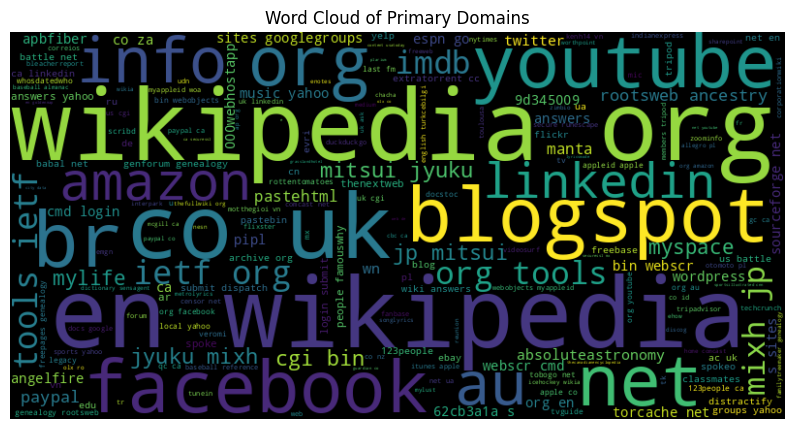

In [10]:
# Convert pri_domain values to strings and filter out None and int values
filtered_domains = urls_data['pri_domain'].map(str).dropna()

# Concatenate all pri_domain values into a single string
text = ' '.join(filtered_domains)

# Generate the WordCloud data
wordcloud = WordCloud(background_color='black', colormap='viridis', width=800, height=400).generate(text)

# Plot the WordCloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Primary Domains', color='black')
plt.show()

In [11]:
def get_url_region(primary_domain):
    ccTLD_to_region = {
    ".ac": "Ascension Island",
    ".ad": "Andorra",
    ".ae": "United Arab Emirates",
    ".af": "Afghanistan",
    ".ag": "Antigua and Barbuda",
    ".ai": "Anguilla",
    ".al": "Albania",
    ".am": "Armenia",
    ".an": "Netherlands Antilles",
    ".ao": "Angola",
    ".aq": "Antarctica",
    ".ar": "Argentina",
    ".as": "American Samoa",
    ".at": "Austria",
    ".au": "Australia",
    ".aw": "Aruba",
    ".ax": "Åland Islands",
    ".az": "Azerbaijan",
    ".ba": "Bosnia and Herzegovina",
    ".bb": "Barbados",
    ".bd": "Bangladesh",
    ".be": "Belgium",
    ".bf": "Burkina Faso",
    ".bg": "Bulgaria",
    ".bh": "Bahrain",
    ".bi": "Burundi",
    ".bj": "Benin",
    ".bm": "Bermuda",
    ".bn": "Brunei Darussalam",
    ".bo": "Bolivia",
    ".br": "Brazil",
    ".bs": "Bahamas",
    ".bt": "Bhutan",
    ".bv": "Bouvet Island",
    ".bw": "Botswana",
    ".by": "Belarus",
    ".bz": "Belize",
    ".ca": "Canada",
    ".cc": "Cocos Islands",
    ".cd": "Democratic Republic of the Congo",
    ".cf": "Central African Republic",
    ".cg": "Republic of the Congo",
    ".ch": "Switzerland",
    ".ci": "Côte d'Ivoire",
    ".ck": "Cook Islands",
    ".cl": "Chile",
    ".cm": "Cameroon",
    ".cn": "China",
    ".co": "Colombia",
    ".cr": "Costa Rica",
    ".cu": "Cuba",
    ".cv": "Cape Verde",
    ".cw": "Curaçao",
    ".cx": "Christmas Island",
    ".cy": "Cyprus",
    ".cz": "Czech Republic",
    ".de": "Germany",
    ".dj": "Djibouti",
    ".dk": "Denmark",
    ".dm": "Dominica",
    ".do": "Dominican Republic",
    ".dz": "Algeria",
    ".ec": "Ecuador",
    ".ee": "Estonia",
    ".eg": "Egypt",
    ".er": "Eritrea",
    ".es": "Spain",
    ".et": "Ethiopia",
    ".eu": "European Union",
    ".fi": "Finland",
    ".fj": "Fiji",
    ".fk": "Falkland Islands",
    ".fm": "Federated States of Micronesia",
    ".fo": "Faroe Islands",
    ".fr": "France",
    ".ga": "Gabon",
    ".gb": "United Kingdom",
    ".gd": "Grenada",
    ".ge": "Georgia",
    ".gf": "French Guiana",
    ".gg": "Guernsey",
    ".gh": "Ghana",
    ".gi": "Gibraltar",
    ".gl": "Greenland",
    ".gm": "Gambia",
    ".gn": "Guinea",
    ".gp": "Guadeloupe",
    ".gq": "Equatorial Guinea",
    ".gr": "Greece",
    ".gs": "South Georgia and the South Sandwich Islands",
    ".gt": "Guatemala",
    ".gu": "Guam",
    ".gw": "Guinea-Bissau",
    ".gy": "Guyana",
    ".hk": "Hong Kong",
    ".hm": "Heard Island and McDonald Islands",
    ".hn": "Honduras",
    ".hr": "Croatia",
    ".ht": "Haiti",
    ".hu": "Hungary",
    ".id": "Indonesia",
    ".ie": "Ireland",
    ".il": "Israel",
    ".im": "Isle of Man",
    ".in": "India",
    ".io": "British Indian Ocean Territory",
    ".iq": "Iraq",
    ".ir": "Iran",
    ".is": "Iceland",
    ".it": "Italy",
    ".je": "Jersey",
    ".jm": "Jamaica",
    ".jo": "Jordan",
    ".jp": "Japan",
    ".ke": "Kenya",
    ".kg": "Kyrgyzstan",
    ".kh": "Cambodia",
    ".ki": "Kiribati",
    ".km": "Comoros",
    ".kn": "Saint Kitts and Nevis",
    ".kp": "Democratic People's Republic of Korea (North Korea)",
    ".kr": "Republic of Korea (South Korea)",
    ".kw": "Kuwait",
    ".ky": "Cayman Islands",
    ".kz": "Kazakhstan",
    ".la": "Laos",
    ".lb": "Lebanon",
    ".lc": "Saint Lucia",
    ".li": "Liechtenstein",
    ".lk": "Sri Lanka",
    ".lr": "Liberia",
    ".ls": "Lesotho",
    ".lt": "Lithuania",
    ".lu": "Luxembourg",
    ".lv": "Latvia",
    ".ly": "Libya",
    ".ma": "Morocco",
    ".mc": "Monaco",
    ".md": "Moldova",
    ".me": "Montenegro",
    ".mf": "Saint Martin (French part)",
    ".mg": "Madagascar",
    ".mh": "Marshall Islands",
    ".mk": "North Macedonia",
    ".ml": "Mali",
    ".mm": "Myanmar",
    ".mn": "Mongolia",
    ".mo": "Macao",
    ".mp": "Northern Mariana Islands",
    ".mq": "Martinique",
    ".mr": "Mauritania",
    ".ms": "Montserrat",
    ".mt": "Malta",
    ".mu": "Mauritius",
    ".mv": "Maldives",
    ".mw": "Malawi",
    ".mx": "Mexico",
    ".my": "Malaysia",
    ".mz": "Mozambique",
    ".na": "Namibia",
    ".nc": "New Caledonia",
    ".ne": "Niger",
    ".nf": "Norfolk Island",
    ".ng": "Nigeria",
    ".ni": "Nicaragua",
    ".nl": "Netherlands",
    ".no": "Norway",
    ".np": "Nepal",
    ".nr": "Nauru",
    ".nu": "Niue",
    ".nz": "New Zealand",
    ".om": "Oman",
    ".pa": "Panama",
    ".pe": "Peru",
    ".pf": "French Polynesia",
    ".pg": "Papua New Guinea",
    ".ph": "Philippines",
    ".pk": "Pakistan",
    ".pl": "Poland",
    ".pm": "Saint Pierre and Miquelon",
    ".pn": "Pitcairn",
    ".pr": "Puerto Rico",
    ".ps": "Palestinian Territory",
    ".pt": "Portugal",
    ".pw": "Palau",
    ".py": "Paraguay",
    ".qa": "Qatar",
    ".re": "Réunion",
    ".ro": "Romania",
    ".rs": "Serbia",
    ".ru": "Russia",
    ".rw": "Rwanda",
    ".sa": "Saudi Arabia",
    ".sb": "Solomon Islands",
    ".sc": "Seychelles",
    ".sd": "Sudan",
    ".se": "Sweden",
    ".sg": "Singapore",
    ".sh": "Saint Helena",
    ".si": "Slovenia",
    ".sj": "Svalbard and Jan Mayen",
    ".sk": "Slovakia",
    ".sl": "Sierra Leone",
    ".sm": "San Marino",
    ".sn": "Senegal",
    ".so": "Somalia",
    ".sr": "Suriname",
    ".ss": "South Sudan",
    ".st": "São Tomé and Príncipe",
    ".sv": "El Salvador",
    ".sx": "Sint Maarten (Dutch part)",
    ".sy": "Syria",
    ".sz": "Eswatini",
    ".tc": "Turks and Caicos Islands",
    ".td": "Chad",
    ".tf": "French Southern Territories",
    ".tg": "Togo",
    ".th": "Thailand",
    ".tj": "Tajikistan",
    ".tk": "Tokelau",
    ".tl": "Timor-Leste",
    ".tm": "Turkmenistan",
    ".tn": "Tunisia",
    ".to": "Tonga",
    ".tr": "Turkey",
    ".tt": "Trinidad and Tobago",
    ".tv": "Tuvalu",
    ".tw": "Taiwan",
    ".tz": "Tanzania",
    ".ua": "Ukraine",
    ".ug": "Uganda",
    ".uk": "United Kingdom",
    ".us": "United States",
    ".uy": "Uruguay",
    ".uz": "Uzbekistan",
    ".va": "Vatican City",
    ".vc": "Saint Vincent and the Grenadines",
    ".ve": "Venezuela",
    ".vg": "British Virgin Islands",
    ".vi": "U.S. Virgin Islands",
    ".vn": "Vietnam",
    ".vu": "Vanuatu",
    ".wf": "Wallis and Futuna",
    ".ws": "Samoa",
    ".ye": "Yemen",
    ".yt": "Mayotte",
    ".za": "South Africa",
    ".zm": "Zambia",
    ".zw": "Zimbabwe"
    }
    
    for ccTLD in ccTLD_to_region:
        if primary_domain.endswith(ccTLD):
            return ccTLD_to_region[ccTLD]
    
    return "Global"

In [12]:
urls_data['url_region'] = urls_data['pri_domain'].apply(lambda x: get_url_region(str(x)))


In [13]:
region_counts = urls_data['url_region'].value_counts()

if 'Global' not in region_counts.index:
    region_counts['Global'] = 0

data = pd.DataFrame({'region': region_counts.index, 'count': region_counts.values})

colorscale = 'YlOrRd'  

fig = go.Figure(data=go.Choropleth(
    locations=data['region'],
    z=data['count'],
    locationmode='country names',
    colorscale=colorscale,
    autocolorscale=True,  
    marker_line_color='white',
    colorbar_title='Count'
))


fig.update_layout(title_text='Distribution of URL Regions')

fig.show()

In [14]:
# Filter out the "Global" category
filtered_data = data[data['region'] != 'Global']

# Plot the filtered data
fig = go.Figure(data=go.Choropleth(
    locations=filtered_data['region'],
    z=filtered_data['count'],
    locationmode='country names',
    colorscale=colorscale,
    autocolorscale=True,  
    marker_line_color='white',
    colorbar_title='Count'
))

# Update layout and title
fig.update_layout(title_text='Distribution of URL Regions (Excluding "Global")')

# Show the plot
fig.show()
